In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt     
import numpy as np
from prophet import Prophet
from scipy.stats import pearsonr
import statsmodels.api as sm
import calendar

In [2]:
flood = pd.read_csv ('merged_dataset.csv')

In [3]:
flood

,datetime,river discharge,Name,day,month,year,Tempmax,Tempmin,Temp,Humidity,Precip,Preciprob,Precipcover,preciptype,Windspeed,Winddir,Sealevelpressure,Cloudcover,Severrisk,Moonphase
0,11/01/2020,139.93,Lagos,11,1,2020,34.0,26.9,29.0,84.0,0.6,100,4.17,rain,20.5,218.5,1013.3,46.9,NaN,0.52
1,14/01/2020,139.93,Lagos,14,1,2020,35.0,26.0,29.4,83.3,1.0,100,4.17,rain,20.4,273.4,1010.1,52.3,NaN,0.63
2,03/03/2020,146.91,Lagos,3,3,2020,33.0,23.0,27.8,82.8,10.0,100,8.33,rain,27.7,202.3,1013.2,42.7,NaN,0.29
3,06/03/2020,178.89,Lagos,6,3,2020,35.0,24.8,28.6,84.4,3.0,100,4.17,rain,25.9,259.4,1010.3,59.2,NaN,0.39
4,09/03/2020,213.29,Lagos,9,3,2020,33.0,26.6,29.6,81.3,0.4,100,12.50,rain,24.4,223.8,1010.1,43.7,NaN,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,29/06/2024,260.22,Lagos,29,6,2024,31.0,23.9,27.1,87.1,12.0,100,4.17,rain,22.3,241.1,1012.7,61.8,30.0,0.77
1414,30/06/2024,274.42,Lagos,30,6,2024,31.2,25.0,27.8,86.2,3.0,100,4.17,rain,25.9,236.9,1013.0,62.4,30.0,0.80
1415,01/07/2024,259.62,Lagos,1,7,2024,32.0,25.0,27.9,84.6,6.9,100,50.00,rain,22.3,249.6,1013.5,55.3,30.0,0.84
1416,02/07/2024,238.33,Lagos,2,7,2024,30.0,24.0,26.9,85.9,13.6,100,62.50,rain,22.7,235.8,1012.7,76.9,30.0,0.87


In [4]:
flood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1418 entries, 0 to 1417
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          1418 non-null   object 
 1   river discharge   1418 non-null   float64
 2   Name              1418 non-null   object 
 3   day               1418 non-null   int64  
 4   month             1418 non-null   int64  
 5   year              1418 non-null   int64  
 6   Tempmax           1418 non-null   float64
 7   Tempmin           1418 non-null   float64
 8   Temp              1418 non-null   float64
 9   Humidity          1418 non-null   float64
 10  Precip            1418 non-null   float64
 11  Preciprob         1418 non-null   int64  
 12  Precipcover       1418 non-null   float64
 13  preciptype        1418 non-null   object 
 14  Windspeed         1418 non-null   float64
 15  Winddir           1418 non-null   float64
 16  Sealevelpressure  1418 non-null   float64


In [5]:
flood = flood.rename (columns = {'Name' : 'State', 'datetime' : 'Date'})  

In [6]:
flood['Severrisk'] = flood['Severrisk'].fillna(flood['Severrisk'].median())

In [7]:
flood.duplicated().value_counts()

False    1096
True      322
Name: count, dtype: int64

In [8]:
duplicated_rows = flood[flood.duplicated(keep=False)]
print("Duplicated rows with all columns:")
print(duplicated_rows)

Duplicated rows with all columns:
            Date  river discharge  State  day  month  year  Tempmax  Tempmin  \
695   20/01/2023            93.19  Lagos   20      1  2023     35.0     25.0   
696   20/01/2023            93.19  Lagos   20      1  2023     35.0     25.0   
697   22/01/2023            93.19  Lagos   22      1  2023     34.8     26.8   
698   22/01/2023            93.19  Lagos   22      1  2023     34.8     26.8   
699   24/01/2023            94.28  Lagos   24      1  2023     35.0     25.0   
...          ...              ...    ...  ...    ...   ...      ...      ...   
1334  29/03/2024            95.16  Lagos   29      3  2024     35.0     28.0   
1335  30/03/2024            97.17  Lagos   30      3  2024     35.0     28.0   
1336  30/03/2024            97.17  Lagos   30      3  2024     35.0     28.0   
1337  31/03/2024           100.62  Lagos   31      3  2024     36.0     27.0   
1338  31/03/2024           100.62  Lagos   31      3  2024     36.0     27.0   

     

In [9]:
flood.drop_duplicates(inplace=True)

In [10]:
flood['Date'] = pd.to_datetime(flood['Date'], dayfirst=True)

In [11]:
flood = flood.drop(columns=['year', 'month', 'day'])

In [12]:
flood.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 0 to 1417
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1096 non-null   datetime64[ns]
 1   river discharge   1096 non-null   float64       
 2   State             1096 non-null   object        
 3   Tempmax           1096 non-null   float64       
 4   Tempmin           1096 non-null   float64       
 5   Temp              1096 non-null   float64       
 6   Humidity          1096 non-null   float64       
 7   Precip            1096 non-null   float64       
 8   Preciprob         1096 non-null   int64         
 9   Precipcover       1096 non-null   float64       
 10  preciptype        1096 non-null   object        
 11  Windspeed         1096 non-null   float64       
 12  Winddir           1096 non-null   float64       
 13  Sealevelpressure  1096 non-null   float64       
 14  Cloudcover        1096 non-nu

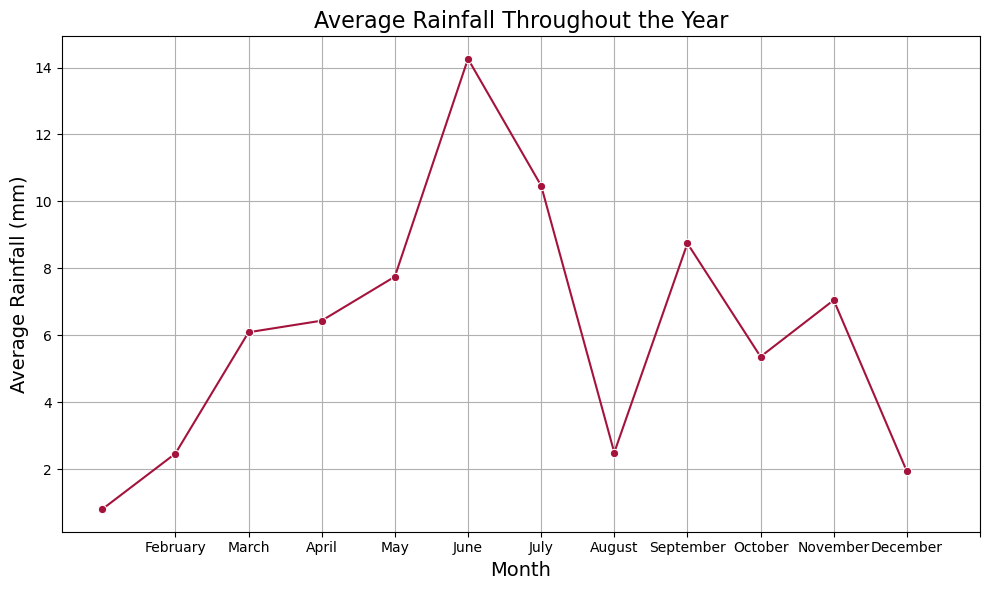

Average Rainfall (mm) Throughout the Year:
        month     Precip
0     January   0.804000
1    February   2.466667
2       March   6.090566
3       April   6.437113
4         May   7.751485
5        June  14.258955
6        July  10.471429
7      August   2.496739
8   September   8.746154
9     October   5.360550
10   November   7.050549
11   December   1.935714


In [13]:
flood['month'] = flood['Date'].dt.month
monthly_avg_precip = flood.groupby('month')['Precip'].mean().reset_index()
monthly_avg_precip['month'] = monthly_avg_precip['month'].apply(lambda x: calendar.month_name[x])
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='Precip', data=monthly_avg_precip, marker='o', color='#a4133c')
plt.title('Average Rainfall Throughout the Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Rainfall (mm)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()
print("Average Rainfall (mm) Throughout the Year:")
print(monthly_avg_precip)


Average Sea Level Pressure Throughout the Year:
        month  Sealevelpressure
0     January       1011.014000
1    February       1010.526389
2       March       1010.089623
3       April       1010.292784
4         May       1012.049505
5        June       1013.177612
6        July       1014.205102
7      August       1013.675000
8   September       1013.132692
9     October       1012.263303
10   November       1011.450549
11   December       1011.188095


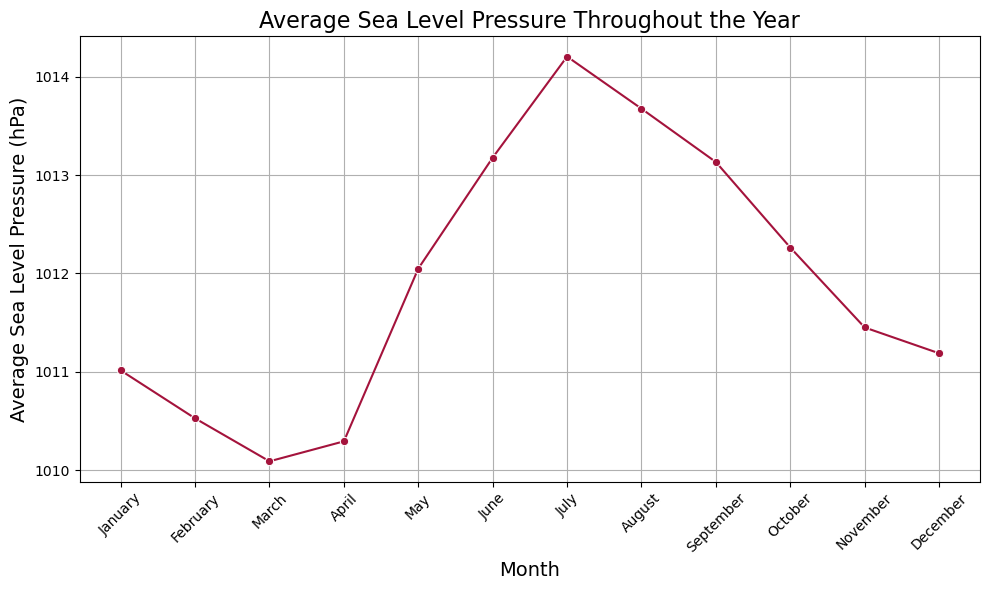

In [14]:
flood['month'] = flood['Date'].dt.month
monthly_sea_level_pressure = flood.groupby('month')['Sealevelpressure'].mean().reset_index()
monthly_sea_level_pressure['month'] = monthly_sea_level_pressure['month'].apply(lambda x: calendar.month_name[x])
print("Average Sea Level Pressure Throughout the Year:")
print(monthly_sea_level_pressure)
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='Sealevelpressure', data=monthly_sea_level_pressure, marker='o', color='#a4133c')
plt.title('Average Sea Level Pressure Throughout the Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Sea Level Pressure (hPa)', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

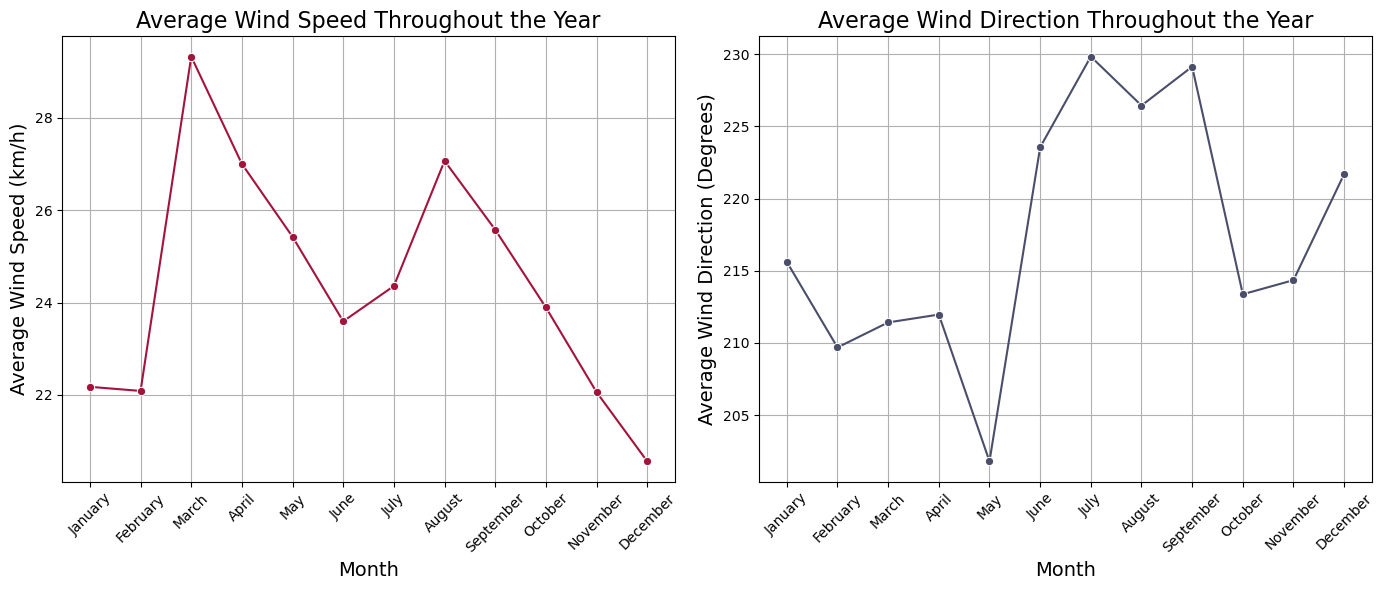

Average Wind Speed and Direction Throughout the Year:
        month  Windspeed     Winddir
0     January  22.174000  215.612000
1    February  22.084722  209.690278
2       March  29.331132  211.422642
3       April  27.005155  211.967010
4         May  25.424752  201.807921
5        June  23.593284  223.550000
6        July  24.359184  229.826531
7      August  27.070652  226.436957
8   September  25.578846  229.125962
9     October  23.894495  213.372477
10   November  22.059341  214.348352
11   December  20.559524  221.690476


In [15]:
flood['month'] = flood['Date'].dt.month
monthly_wind = flood.groupby('month').agg({'Windspeed': 'mean', 'Winddir': 'mean'}).reset_index()
monthly_wind['month'] = monthly_wind['month'].apply(lambda x: calendar.month_name[x])
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='month', y='Windspeed', data=monthly_wind, marker='o', color='#a4133c')
plt.title('Average Wind Speed Throughout the Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Wind Speed (km/h)', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.lineplot(x='month', y='Winddir', data=monthly_wind, marker='o', color='#4a4e69')
plt.title('Average Wind Direction Throughout the Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Wind Direction (Degrees)', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
print("Average Wind Speed and Direction Throughout the Year:")
print(monthly_wind)


Correlation matrix:
            Cloudcover    Precip  Severrisk
Cloudcover    1.000000  0.071787  -0.274023
Precip        0.071787  1.000000  -0.057050
Severrisk    -0.274023 -0.057050   1.000000


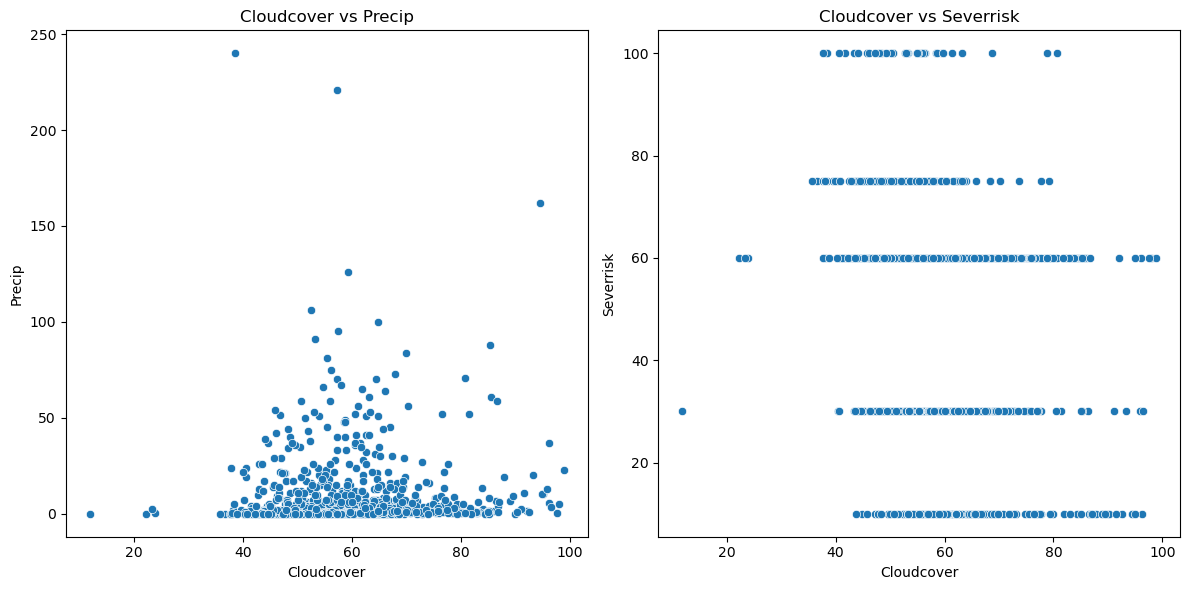

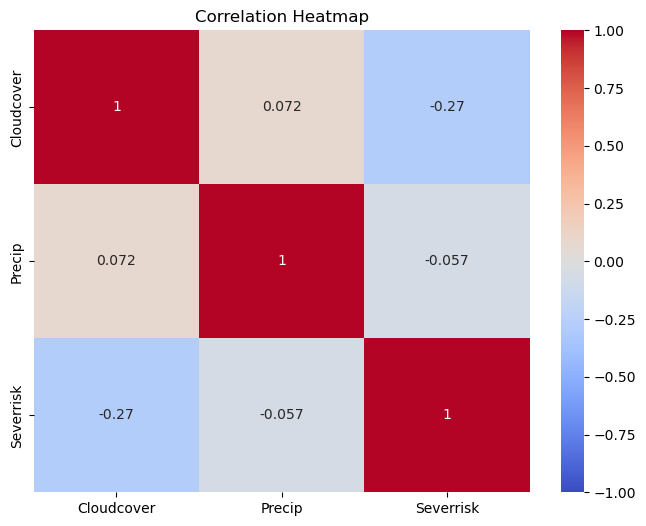

In [16]:
correlation_matrix = flood[['Cloudcover', 'Precip', 'Severrisk']].corr()
print("Correlation matrix:")
print(correlation_matrix)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=flood, x='Cloudcover', y='Precip')
plt.title('Cloudcover vs Precip')

plt.subplot(1, 2, 2)
sns.scatterplot(data=flood, x='Cloudcover', y='Severrisk')
plt.title('Cloudcover vs Severrisk')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [17]:
relevant_columns = [
    'river discharge', 'Tempmax', 'Tempmin', 'Humidity', 'Precip', 'Preciprob',
    'Precipcover', 'Windspeed', 'Sealevelpressure', 'Cloudcover', 'Severrisk'
]

percentiles = flood[relevant_columns].quantile(0.90)

print(percentiles)


river discharge      658.945
Tempmax               34.800
Tempmin               26.650
Humidity              89.200
Precip                19.000
Preciprob            100.000
Precipcover           20.830
Windspeed             35.150
Sealevelpressure    1014.300
Cloudcover            72.800
Severrisk             75.000
Name: 0.9, dtype: float64


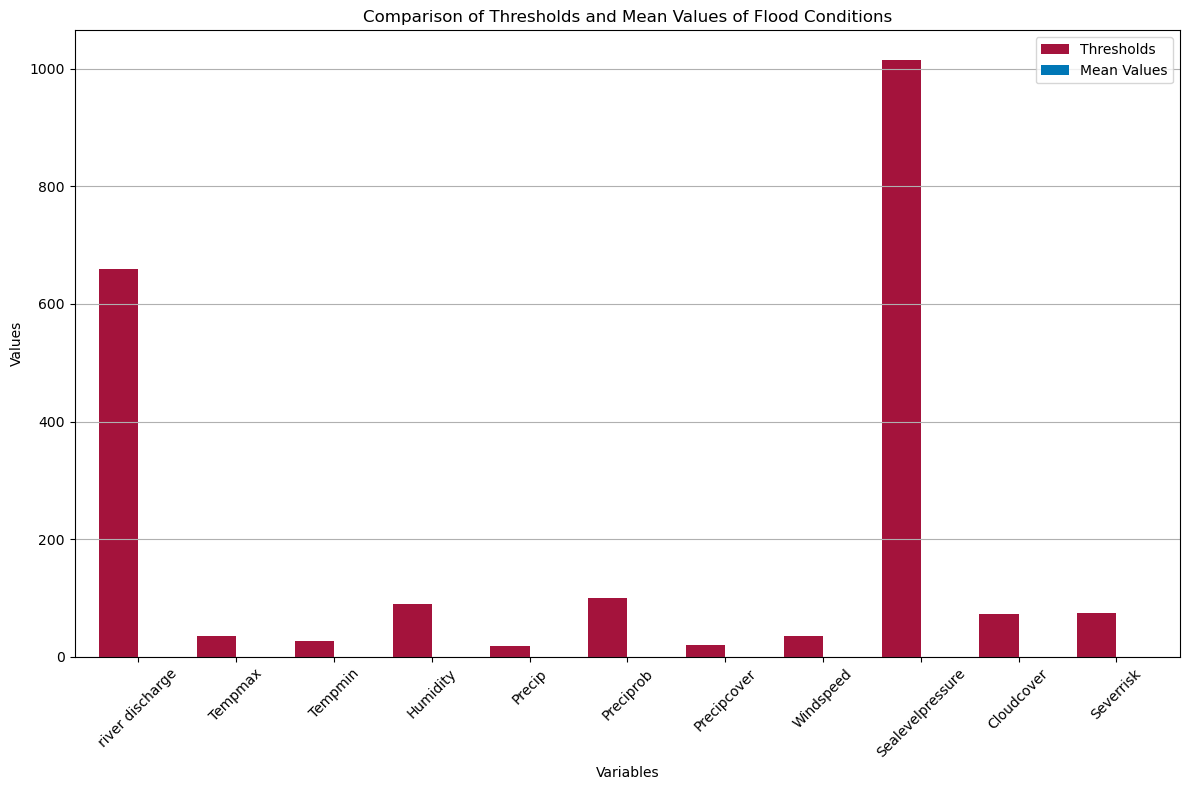

Thresholds vs. Mean Values for Flood Conditions:
                  Thresholds  Mean Values
river discharge      658.945          NaN
Tempmax               34.800          NaN
Tempmin               26.650          NaN
Humidity              89.200          NaN
Precip                19.000          NaN
Preciprob            100.000          NaN
Precipcover           20.830          NaN
Windspeed             35.150          NaN
Sealevelpressure    1014.300          NaN
Cloudcover            72.800          NaN
Severrisk             75.000          NaN


In [35]:
thresholds = {
    'river discharge': 658.945,       
    'Tempmax': 34.800,                
    'Tempmin': 26.650,                
    'Humidity': 89.200,               
    'Precip': 19.000,                
    'Preciprob': 100.000,              
    'Precipcover': 20.830,           
    'Windspeed': 35.150,             
    'Sealevelpressure': 1014.300,     
    'Cloudcover': 72.800,             
    'Severrisk': 75.000                
}

flood_conditions = flood[
    (flood['river discharge'] >= thresholds['river discharge']) &
    (flood['Tempmax'] >= thresholds['Tempmax']) &
    (flood['Tempmin'] >= thresholds['Tempmin']) &
    (flood['Humidity'] >= thresholds['Humidity']) &
    (flood['Precip'] >= thresholds['Precip']) &
    (flood['Preciprob'] >= thresholds['Preciprob']) &
    (flood['Precipcover'] >= thresholds['Precipcover']) &
    (flood['Windspeed'] >= thresholds['Windspeed']) &
    (flood['Sealevelpressure'] <= thresholds['Sealevelpressure']) &  
    (flood['Cloudcover'] >= thresholds['Cloudcover']) &
    (flood['Severrisk'] >= thresholds['Severrisk'])
]

relevant_columns = list(thresholds.keys())

mean_values = flood_conditions[relevant_columns].mean()

plot_data = pd.DataFrame({
    'Thresholds': thresholds,
    'Mean Values': mean_values
})

plt.figure(figsize=(12, 8))
plot_data.plot(kind='bar', width=0.8, color=['#a4133c', '#0077b6'], ax=plt.gca())
plt.title('Comparison of Thresholds and Mean Values of Flood Conditions')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(['Thresholds', 'Mean Values'])
plt.tight_layout()
plt.show()
print("Thresholds vs. Mean Values for Flood Conditions:")
print(plot_data)

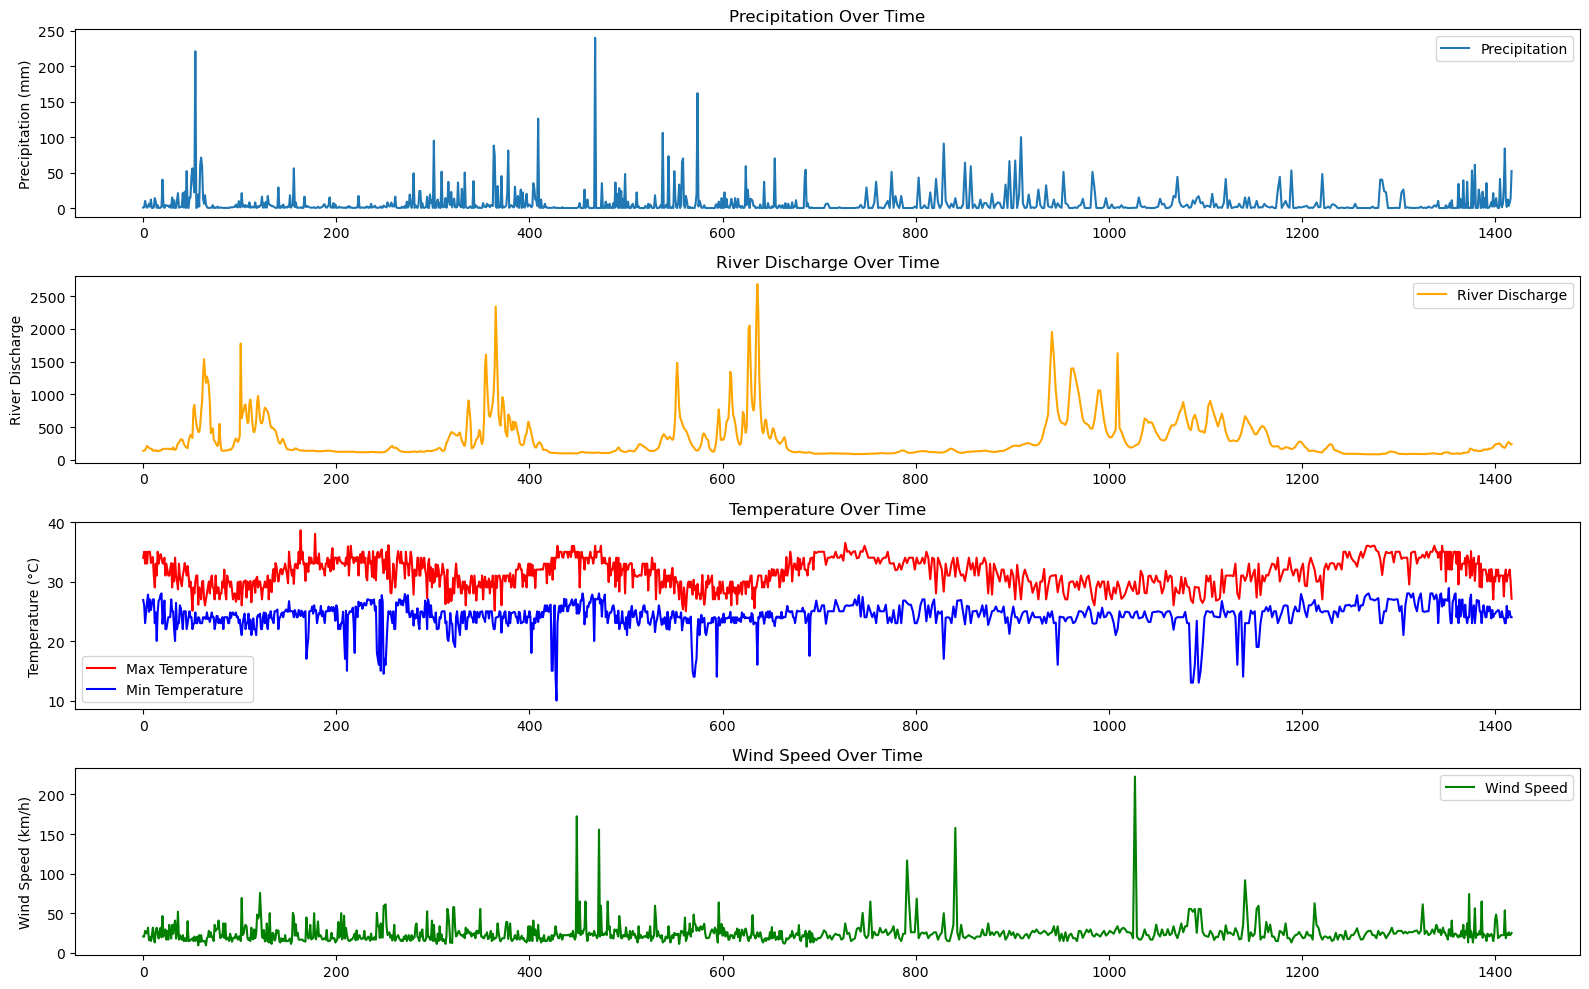

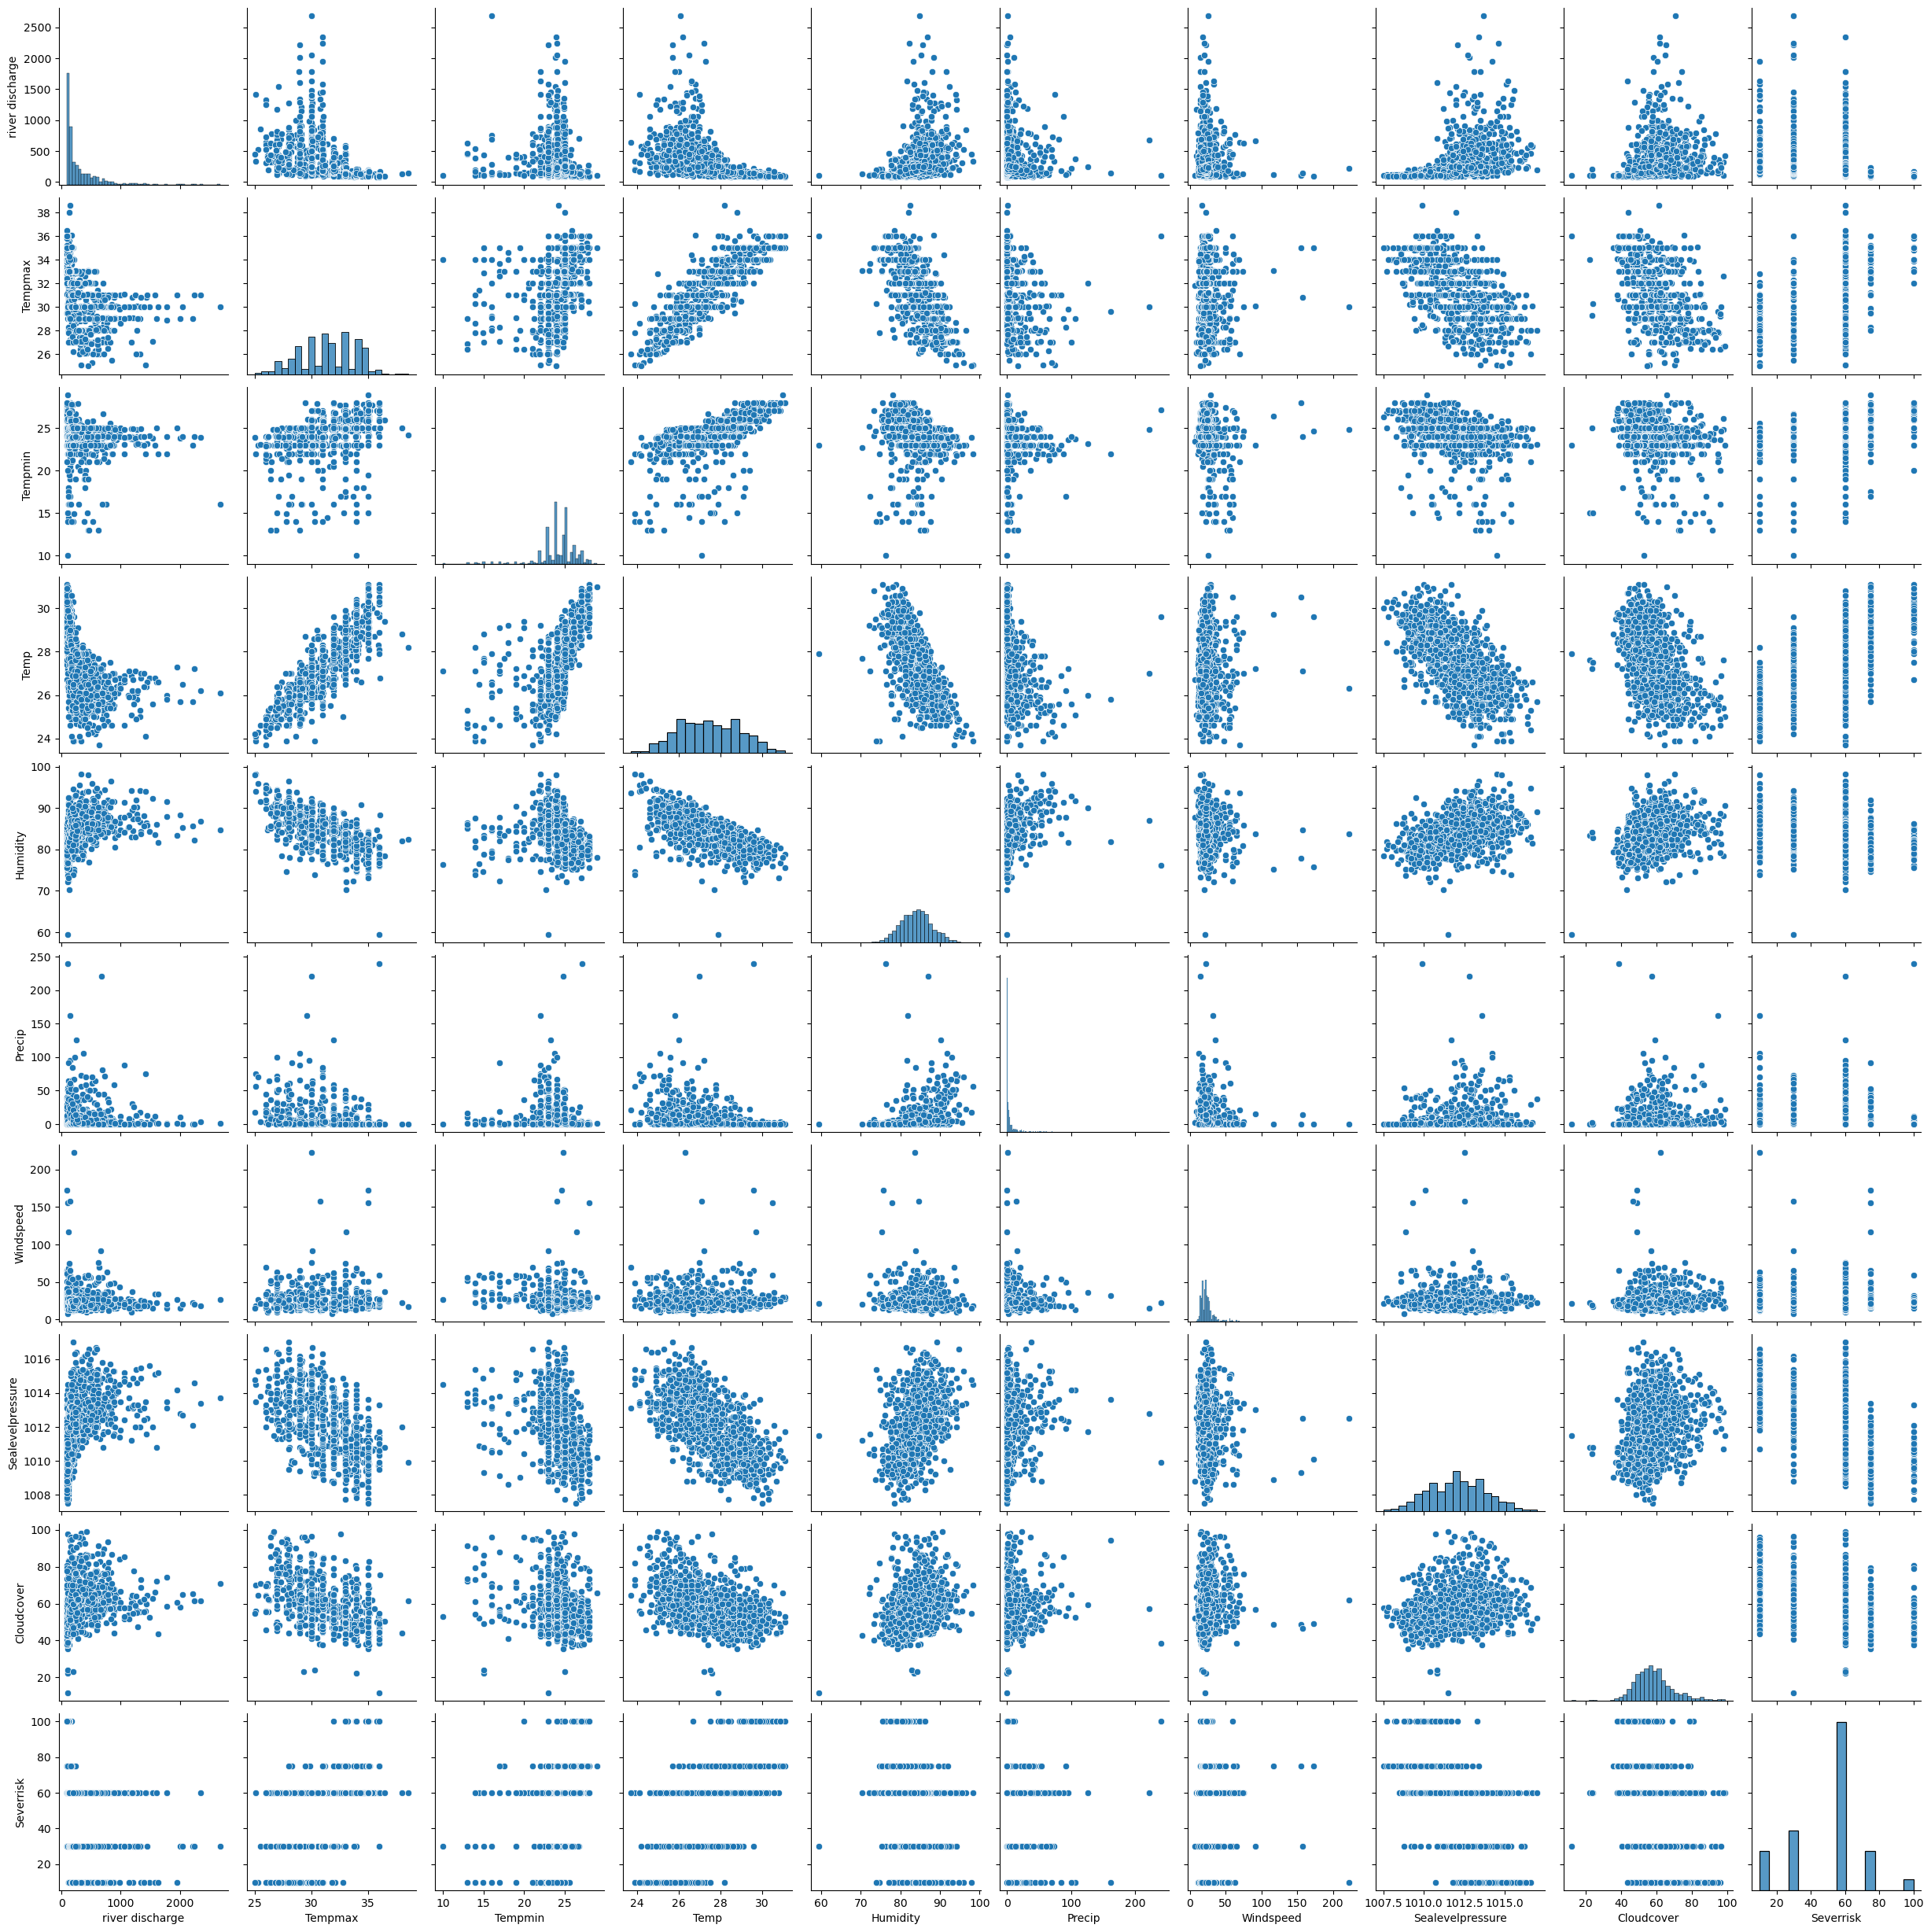

In [41]:
plt.figure(figsize=(16, 10))

plt.subplot(4, 1, 1)
plt.plot(flood.index, flood['Precip'], label='Precipitation')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation Over Time')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(flood.index, flood['river discharge'], label='River Discharge', color='orange')
plt.ylabel('River Discharge')
plt.title('River Discharge Over Time')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(flood.index, flood['Tempmax'], label='Max Temperature', color='red')
plt.plot(flood.index, flood['Tempmin'], label='Min Temperature', color='blue')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(flood.index, flood['Windspeed'], label='Wind Speed', color='green')
plt.ylabel('Wind Speed (km/h)')
plt.title('Wind Speed Over Time')
plt.legend()

plt.tight_layout()
plt.show()


sns.pairplot(flood[['river discharge', 'Tempmax', 'Tempmin', 'Temp', 'Humidity', 'Precip', 'Windspeed', 'Sealevelpressure', 'Cloudcover', 'Severrisk']])
plt.show()

18:46:22 - cmdstanpy - INFO - Chain [1] start processing
18:46:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


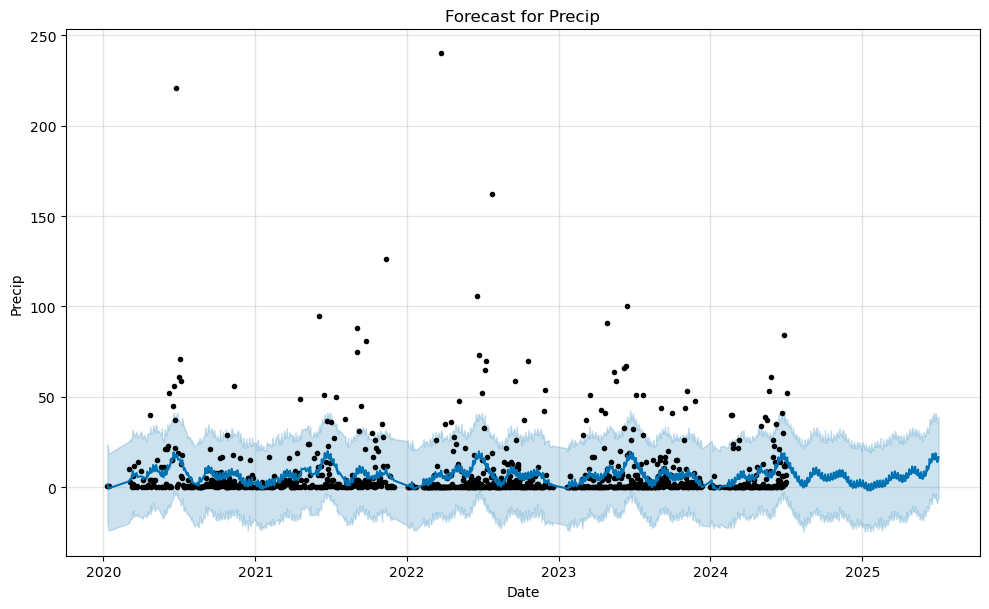

18:46:23 - cmdstanpy - INFO - Chain [1] start processing
18:46:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


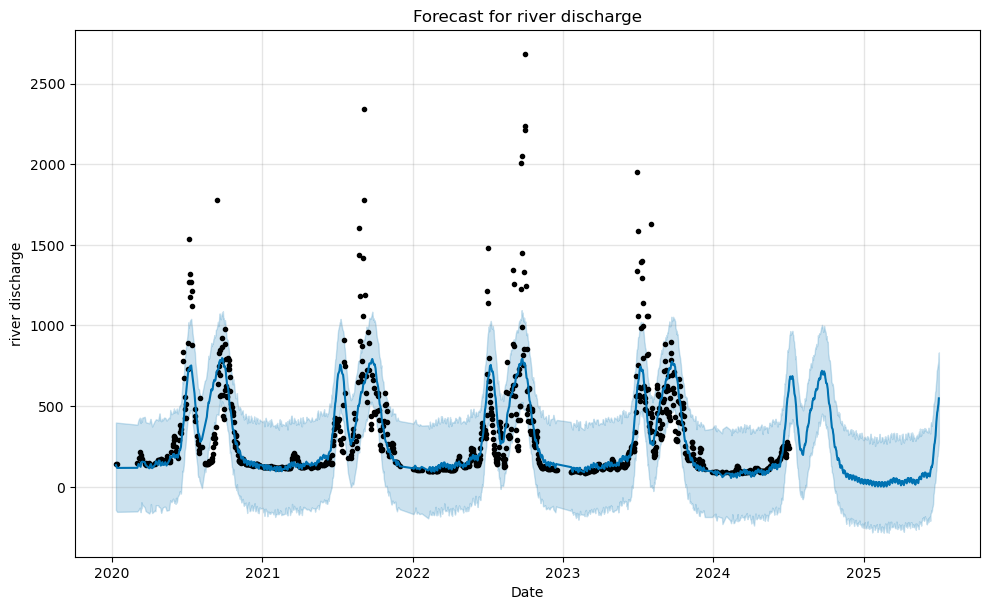

18:46:24 - cmdstanpy - INFO - Chain [1] start processing
18:46:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


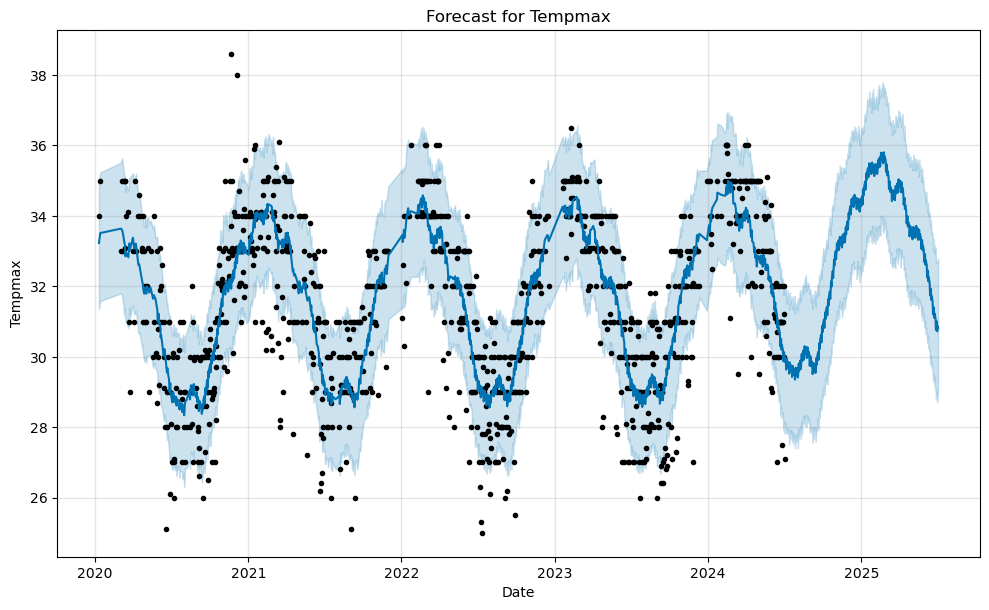

18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


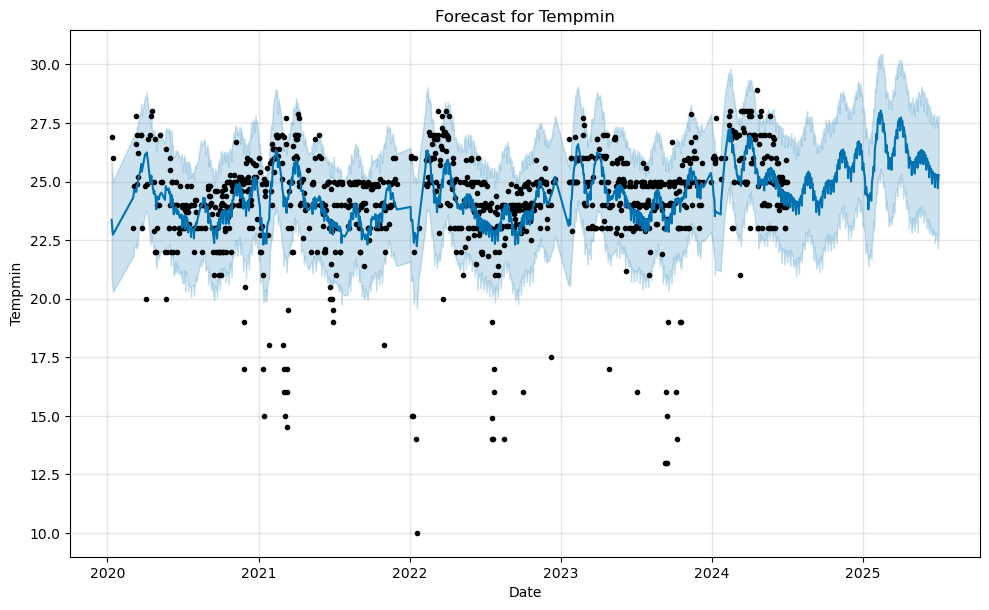

18:46:28 - cmdstanpy - INFO - Chain [1] start processing
18:46:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\FOLAKEMI\New folder\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


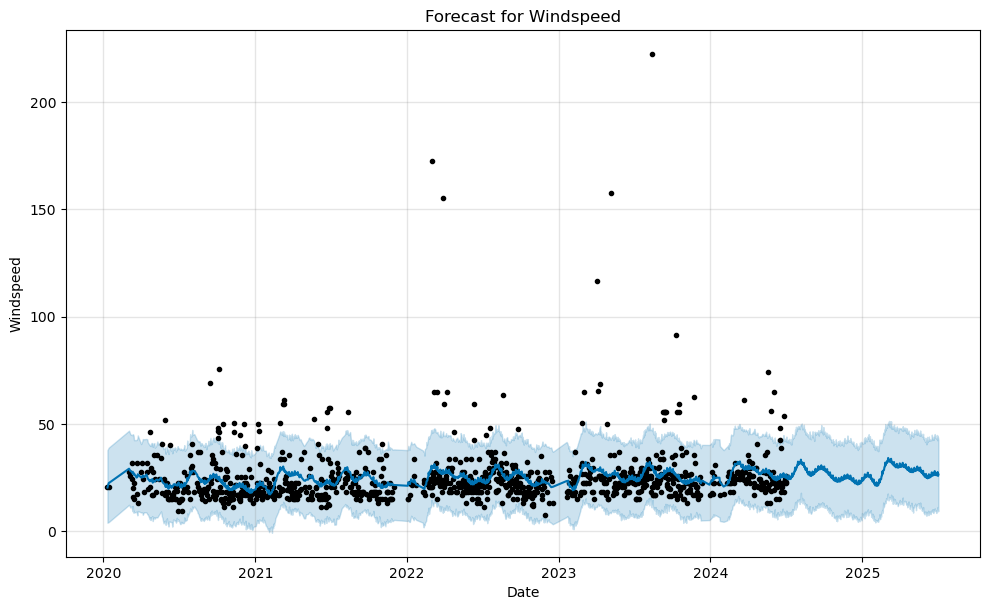


Forecast summary for Precip:
             ds       yhat  yhat_lower  yhat_upper
1456 2025-06-29  15.019560   -8.453863   36.441891
1457 2025-06-30  14.095436   -8.551265   35.858478
1458 2025-07-01  14.033508   -7.312115   36.583845
1459 2025-07-02  15.120112   -6.761037   38.056927
1460 2025-07-03  16.732315   -4.232369   38.760846

Forecast summary for river discharge:
             ds        yhat  yhat_lower  yhat_upper
1456 2025-06-29  460.582118  187.636262  730.350001
1457 2025-06-30  471.991759  189.796754  748.663672
1458 2025-07-01  495.782662  220.400548  764.146861
1459 2025-07-02  512.543979  242.653271  781.642250
1460 2025-07-03  548.024189  273.599466  832.928554

Forecast summary for Tempmax:
             ds       yhat  yhat_lower  yhat_upper
1456 2025-06-29  30.848879   28.972656   32.713562
1457 2025-06-30  31.003614   29.006347   32.707088
1458 2025-07-01  30.722867   28.720420   32.708291
1459 2025-07-02  30.872959   28.915052   32.669038
1460 2025-07-03  30.823873 

In [20]:
forecast_columns = ['Precip', 'river discharge', 'Tempmax', 'Tempmin', 'Windspeed']
forecasts = {}

for column in forecast_columns:
    df = flood[['Date', column]].rename(columns={'Date': 'ds', column: 'y'})
    
    model = Prophet()
    model.fit(df)
    
   
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    
   
    forecasts[column] = forecast

  
    fig = model.plot(forecast)
    plt.title(f'Forecast for {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()


for column in forecast_columns:
    print(f"\nForecast summary for {column}:")
    print(forecasts[column][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())



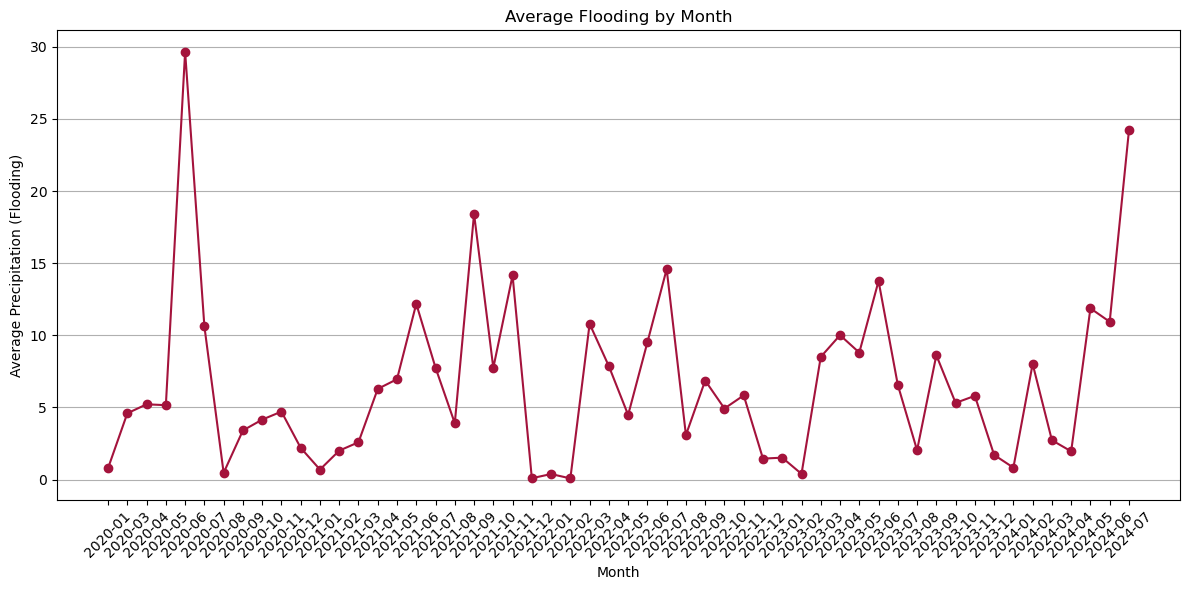

   YearMonth     Precip
0    2020-01   0.800000
1    2020-03   4.600000
2    2020-04   5.221429
3    2020-05   5.161538
4    2020-06  29.655000
5    2020-07  10.623529
6    2020-08   0.473333
7    2020-09   3.408000
8    2020-10   4.160000
9    2020-11   4.714815
10   2020-12   2.203846
11   2021-01   0.700000
12   2021-02   2.010000
13   2021-03   2.592000
14   2021-04   6.288235
15   2021-05   6.960000
16   2021-06  12.188000
17   2021-07   7.758824
18   2021-08   3.909524
19   2021-09  18.415000
20   2021-10   7.747619
21   2021-11  14.152941
22   2021-12   0.100000
23   2022-01   0.388889
24   2022-02   0.088235
25   2022-03  10.796296
26   2022-04   7.859091
27   2022-05   4.484000
28   2022-06   9.516667
29   2022-07  14.586667
30   2022-08   3.092000
31   2022-09   6.866667
32   2022-10   4.930000
33   2022-11   5.840909
34   2022-12   1.457143
35   2023-01   1.525000
36   2023-02   0.400000
37   2023-03   8.504762
38   2023-04  10.013043
39   2023-05   8.804348
40   2023-06  13

In [21]:

# Extract month and year from 'datetime'
flood['YearMonth'] = flood['Date'].dt.to_period('M')

# Calculate the average flooding for each month
average_flooding_by_month = flood.groupby('YearMonth')['Precip'].mean().reset_index()

# Convert 'YearMonth' back to string for plotting
average_flooding_by_month['YearMonth'] = average_flooding_by_month['YearMonth'].astype(str)

# Plot the average flooding by month
plt.figure(figsize=(12, 6))
plt.plot(average_flooding_by_month['YearMonth'], average_flooding_by_month['Precip'], marker='o', color='#a4133c')
plt.title('Average Flooding by Month')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (Flooding)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print the average flooding by month
print(average_flooding_by_month)


Future Flood Predictions:
           ds  Flood_Prediction
0  2024-08-31         25.691976
1  2024-09-30         28.842724
2  2024-10-31         23.909025
3  2024-11-30         24.396983
4  2024-12-31         24.794639
5  2025-01-31         21.967640
6  2025-02-28         31.876316
7  2025-03-31         30.110242
8  2025-04-30         27.454999
9  2025-05-31         25.349149
10 2025-06-30         26.240433
11 2025-07-31         32.678857


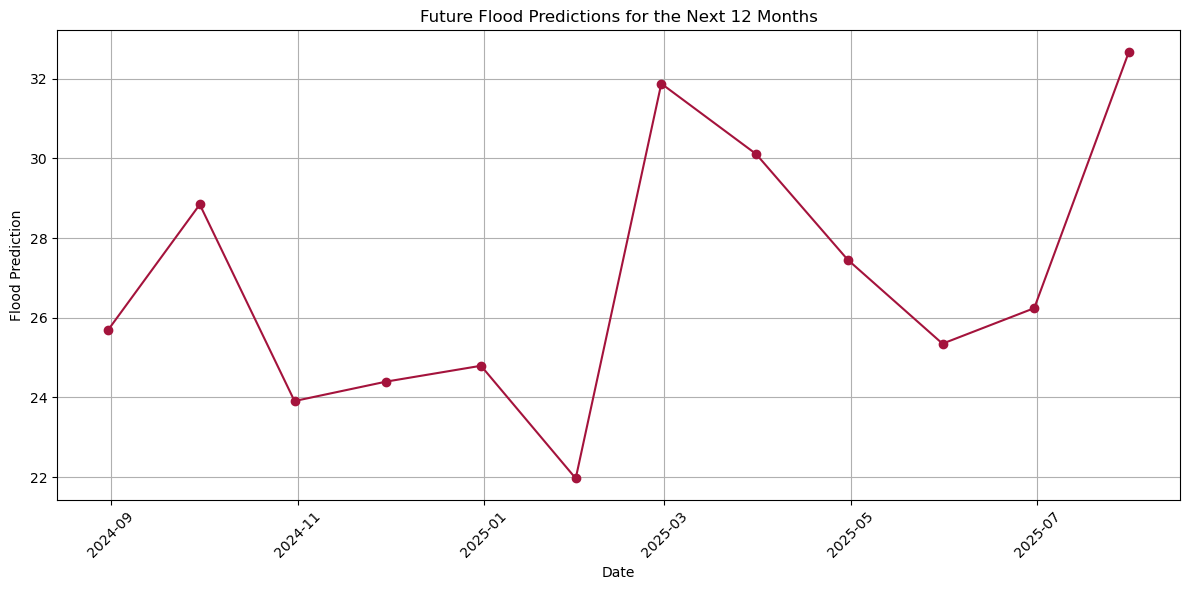

In [22]:
dates = pd.date_range(start='2024-08-01', periods=12, freq='ME')  
np.random.seed(42)
future_data = pd.DataFrame({
    'date': dates, 
    'Tempmax': np.random.uniform(low=25, high=35, size=len(dates)),
    'Tempmin': np.random.uniform(low=20, high=30, size=len(dates)),
    'Temp': np.random.uniform(low=22, high=33, size=len(dates)),
    'Humidity': np.random.uniform(low=60, high=100, size=len(dates)),
    'Precip': np.random.uniform(low=0, high=20, size=len(dates)),
    'Preciprob': np.random.uniform(low=0, high=100, size=len(dates)),
    'Precipcover': np.random.uniform(low=0, high=100, size=len(dates)),
    'Windspeed': np.random.uniform(low=0, high=10, size=len(dates)),
    'Winddir': np.random.uniform(low=0, high=360, size=len(dates)),
    'Sealevelpressure': np.random.uniform(low=1000, high=1020, size=len(dates)),
    'Cloudcover': np.random.uniform(low=0, high=100, size=len(dates)),
    'Moonphase': np.random.uniform(low=0, high=1, size=len(dates)),
    'Severrisk': np.random.uniform(low=0, high=100, size=len(dates))  # Add this line
})

future_data.rename(columns={'date': 'ds'}, inplace=True)

features = ['ds', 'Tempmax', 'Tempmin', 'Temp', 'Humidity', 'Precip', 'Preciprob', 'Precipcover', 
            'Windspeed', 'Winddir', 'Sealevelpressure', 'Cloudcover', 'Moonphase', 'Severrisk']

future_data_processed = future_data[features]

future_predictions = model.predict(future_data_processed)

future_data['Flood_Prediction'] = future_predictions['yhat']  

print('Future Flood Predictions:')
print(future_data[['ds', 'Flood_Prediction']])

plt.figure(figsize=(12, 6))
plt.plot(future_data['ds'], future_data['Flood_Prediction'], marker='o', color='#a4133c', linestyle='-')
plt.title('Future Flood Predictions for the Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Flood Prediction')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
pip install cdsapi

Note: you may need to restart the kernel to use updated packages.


In [24]:
with open('C:\\Users\\FOLAKEMI\\.cdsapirc', 'w') as file:
    file.write("url: https://cds.climate.copernicus.eu/api/v2\n")
    file.write("key: 329637:77e05bde-a28d-4b50-a50c-e1934beace83\n")
    file.write("verify: 1\n")



In [25]:
import cdsapi

# Initialize the CDS API client
c = cdsapi.Client()

# Define the area of interest (India)
area = [37.0, 68.0, 8.0, 97.0]  # [North, West, South, East]

# Request daily precipitation data
c.retrieve(
    'reanalysis-era5-single-levels',  # ERA5 reanalysis dataset
    {
        'product_type': 'reanalysis',
        'variable': 'total_precipitation',
        'year': ['2020', '2021', '2022', '2023', '2024'],
        'month': [
            '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'
        ],
        'day': [
            '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
            '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
            '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'
        ],
        'time': '00:00',
        'format': 'netcdf',  # Choose the format of the output file (NetCDF is commonly used)
        'area': area,
    },
    'india_precipitation_2020_2024.nc'  # Output file name
)


2024-08-13 18:46:41,243 INFO Welcome to the CDS.
 As per our announcements on the Forum, this instance of CDS will soon be decommissioned.
 Please update your cdsapi package to a version >=0.7.0, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
 The current legacy system will be kept for a while, but we will reduce resources gradually until full decommissioning in September 2024.
2024-08-13 18:46:41,245 WARNING MOVE TO CDS-Beta
2024-08-13 18:46:41,248 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-08-13 18:46:41,528 INFO Request is queued
2024-08-13 18:47:03,457 INFO Request is running
2024-08-13 18:51:02,965 INFO Request is completed
2024-08-13 18:51:02,966 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data3/adaptor.mars.internal-1723571455.4828684-22543-17-b84b7ccd-645e-4bc7-ba4

Result(content_length=92108428,content_type=application/x-netcdf,location=https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data3/adaptor.mars.internal-1723571455.4828684-22543-17-b84b7ccd-645e-4bc7-ba48-30c53f27afaf.nc)

In [26]:
import xarray as xr
data = xr.open_dataset('india_precipitation_2020_2024.nc')

# Extract precipitation data
precipitation = data['tp']  
# Convert to a Pandas DataFrame
df = precipitation.to_dataframe().reset_index()

# Display the first few rows to understand the structure
print("Initial DataFrame:")
print(df.head())
print(df.columns)

# Ensure 'time' is in datetime format
df['time'] = pd.to_datetime(df['time'])

# Convert 'time' to 'date' (removing the time component)
df['date'] = df['time'].dt.date

# Drop the old 'time' column if desired
df = df.drop(columns=['time'])

# Check for duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Aggregate data by year, month, latitude, and longitude
monthly_df = df.groupby([df['date'], 'latitude', 'longitude']).agg({'tp': 'sum'}).reset_index()

# Check the resulting DataFrame
print("Aggregated DataFrame:")
print(monthly_df.head())

# Randomly sample 1,096 rows from the aggregated DataFrame
sampled_df = monthly_df.sample(n=1096, random_state=1)
sampled_df.to_csv('sampled_india_precipitation.csv', index=False)


Initial DataFrame:
        time  expver  latitude  longitude            tp
0 2020-01-01       1      37.0      68.00 -1.862645e-09
1 2020-01-01       1      37.0      68.25 -1.862645e-09
2 2020-01-01       1      37.0      68.50 -1.862645e-09
3 2020-01-01       1      37.0      68.75 -1.862645e-09
4 2020-01-01       1      37.0      69.00 -1.862645e-09
Index(['time', 'expver', 'latitude', 'longitude', 'tp'], dtype='object')
Aggregated DataFrame:
         date  latitude  longitude        tp
0  2020-01-01       8.0      68.00  0.000438
1  2020-01-01       8.0      68.25  0.000307
2  2020-01-01       8.0      68.50  0.000205
3  2020-01-01       8.0      68.75  0.000159
4  2020-01-01       8.0      69.00  0.000159


In [27]:
sampled_df

,date,latitude,longitude,tp
13574895,2022-09-18,27.25,89.75,3.157184e-06
18428217,2023-09-08,14.00,71.75,5.470999e-04
21323192,2024-04-06,28.00,82.75,-1.862645e-09
220726,2020-01-17,11.50,84.00,1.086611e-04
11030051,2022-03-16,30.00,95.50,-1.862645e-09
...,...,...,...,...
15192135,2023-01-14,31.50,77.00,3.082957e-04
14859983,2022-12-21,23.75,79.75,-1.862645e-09
10768872,2022-02-25,27.75,86.75,1.894310e-06
14544030,2022-11-28,21.25,95.75,1.894310e-06


Correlation between Lagos and India rainfall: -0.01


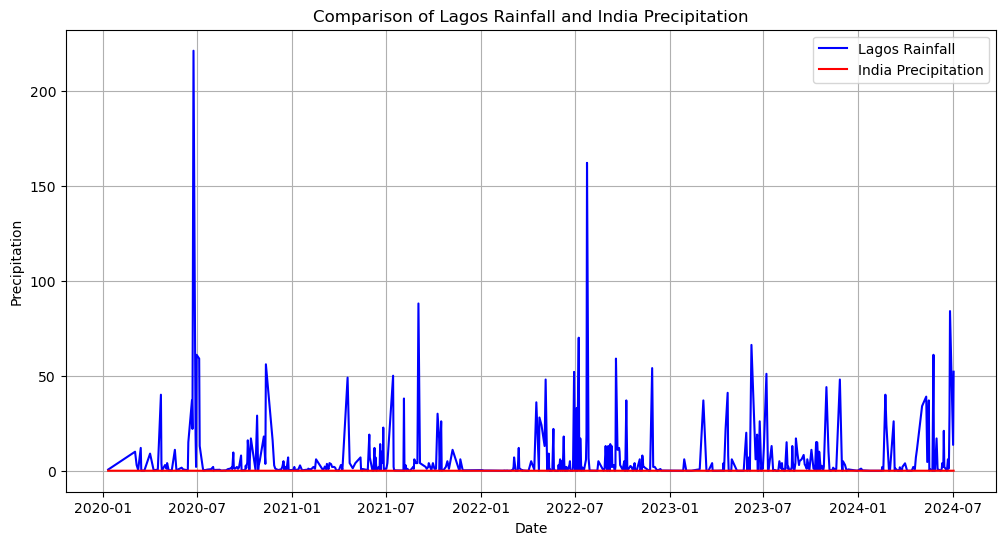

In [34]:
sampled_df = pd.read_csv('sampled_india_precipitation.csv')

india_precip = sampled_df[['date', 'tp']].copy() 

india_precip.rename(columns={'date': 'Date'}, inplace=True)

flood['Date'] = pd.to_datetime(flood['Date'])
india_precip['Date'] = pd.to_datetime(india_precip['Date'])

merged_df = pd.merge(flood, india_precip, on='Date', how='inner')

correlation = merged_df[['Precip', 'tp']].corr().iloc[0, 1]
print(f"Correlation between Lagos and India rainfall: {correlation:.2f}")


plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Precip'], label='Lagos Rainfall', color='blue')
plt.plot(merged_df['Date'], merged_df['tp'], label='India Precipitation', color='red')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Comparison of Lagos Rainfall and India Precipitation')
plt.legend()
plt.grid(True)

plt.show()
